In [2]:
import pandas as pd
import numpy as np
import os
#Read the data from GitHub directly
url = "https://github.com/renatoquiliche/PaperCienciaDados-PunoPeru/blob/main/Databases/peru_2019.csv?raw=true"

data_puno = pd.read_csv(url)


In [13]:
# Set the random seed for reproductible results
np.random.seed(0)

Y = data_puno["disasters_risk"]

In [14]:
from preprocessing import preprocessing
x = preprocessing(data_puno, umbral=0.02)


Old data dimension (1106, 86)
Features removed : 13
New data dimension (1106, 73)


In [19]:

# Init the grid search cross-validation on RFC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import matthews_corrcoef, make_scorer, accuracy_score, f1_score, roc_curve
#from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# I define here the NPV metric
def neg_pred_value(y_true,y_predicted):
    cm = confusion_matrix(y_true, y_predicted)
    if (cm[1][0]+cm[0][0])==0:
        neg_pred_value=0
    else:
        neg_pred_value = cm[0][0]/(cm[1][0]+cm[0][0])
    return neg_pred_value


In [20]:
from scipy.stats import uniform, randint

def RFCexperiments(K_folds, Repeats, n_iter):
    # Cross-validation method
    cv = RepeatedStratifiedKFold(n_splits=K_folds, n_repeats=Repeats, random_state=0)
    
    # Hyperparameter grid for RFC
    param_grid = {'criterion': ['gini', 'entropy'],
                  'max_depth': randint(7,10),
                  'min_samples_split': uniform(0, 0.015),
                  'min_samples_leaf': uniform(0, 0.003),
                  'n_estimators': randint(60,90),
                  'max_features': uniform(0.05,0.15)}
    
    # I define the model here
    RFC = RandomForestClassifier(random_state=0, n_jobs=-1, bootstrap=True)
    scoring = {"AUC": "roc_auc"
               , "Accuracy": make_scorer(accuracy_score)
               , "F1-Score": "f1"
               , "MCC": make_scorer(matthews_corrcoef)
               , "NPV": make_scorer(neg_pred_value)}
    
    #Test CV
    search_ddnn = RandomizedSearchCV(random_state=0, estimator = RFC, param_distributions=param_grid
                                     , scoring=scoring, cv=cv, n_jobs=-1, refit="MCC", verbose=10, n_iter=n_iter)
    results = search_ddnn.fit(x, Y)
    return results


## Running this cell will perform RSCV

In [6]:
import time
start = time.time()

K = 10
Repeats = 2
n_iter = 2000
RFC_results =  RFCexperiments(K, Repeats, n_iter)

Total_time = (time.time() - start)
print("Training time: ", Total_time, " seconds")


Fitting 20 folds for each of 2000 candidates, totalling 40000 fits
Training time:  670.9430232048035  seconds


In [7]:
pd.DataFrame(RFC_results.cv_results_).to_csv("..\Resultados\RFC\RFC_results.csv", index=False)

In [8]:
cutoff = round(n_iter*0.05)

results_dataset = pd.DataFrame(RFC_results.cv_results_)
sorted_results = results_dataset.sort_values(by=["rank_test_MCC"])

# Select the 5% best MCC
step4 = sorted_results.iloc[0:cutoff,:]

# Select the best NPV over 5% best MCC
step5 = step4.sort_values(by=["rank_test_NPV"])
print(step4["mean_test_MCC"].iloc[0], step4["mean_test_NPV"].iloc[0])
print(step5["mean_test_MCC"].iloc[0], step5["mean_test_NPV"].iloc[0])

print("Change in MCC: ", 100*(step5["mean_test_MCC"].iloc[0]-step4["mean_test_MCC"].iloc[0])/(step4["mean_test_MCC"].iloc[0]))
print("Change in NPV: ", 100*(step5["mean_test_NPV"].iloc[0]-step4["mean_test_NPV"].iloc[0])/(step4["mean_test_NPV"].iloc[0]))
print("Percentil 5 cutoff: ", cutoff, " best results")

0.5649535025177582 0.8186648353813377
0.5637323566804724 0.8225976337119061
Change in MCC:  -0.21614979495546122
Change in NPV:  0.4803917501521182
Percentil 5 cutoff:  100  best results


In [70]:
print("AUC", "\t\t Accuracy", "\t\t F1-Score")
print(step4["mean_test_AUC"].iloc[0], step4["mean_test_Accuracy"].iloc[0], step4["mean_test_F1-Score"].iloc[0])
print(step5["mean_test_AUC"].iloc[0], step5["mean_test_Accuracy"].iloc[0], step5["mean_test_F1-Score"].iloc[0])

AUC 		 Accuracy 		 F1-Score
0.8283067818468041 0.7861752661752662 0.824409490324957
0.8292492875572405 0.7852702702702703 0.8244602884410581


In [66]:
display(step4[["rank_test_MCC", "rank_test_NPV"]].head(10))
display(step5[["rank_test_MCC", "rank_test_NPV"]].head(10))

print("Parameters before NPV maximization: ")
display(step4["params"].iloc[0])

print("Parameters after NPV maximization: ")
display(step5["params"].iloc[0])

,rank_test_MCC,rank_test_NPV
1929,1,23
630,2,1
287,2,1
959,4,5
1462,5,7
851,6,174
1546,7,8
1319,8,6
1733,9,4
1827,10,41


,rank_test_MCC,rank_test_NPV
630,2,1
287,2,1
1276,12,3
1733,9,4
959,4,5
1319,8,6
1462,5,7
1546,7,8
1337,41,9
1569,40,10


Parameters before NPV maximization: 


"{'criterion': 'entropy', 'max_depth': 9, 'max_features': 0.1417321632369702, 'min_samples_leaf': 0.0023572481924583194, 'min_samples_split': 0.012308008568602133, 'n_estimators': 66}"

Parameters after NPV maximization: 


"{'criterion': 'entropy', 'max_depth': 9, 'max_features': 0.1412288575695536, 'min_samples_leaf': 0.00011405469762752375, 'min_samples_split': 0.0019258486522183338, 'n_estimators': 87}"

<AxesSubplot:xlabel='Repeat', ylabel='MCC'>

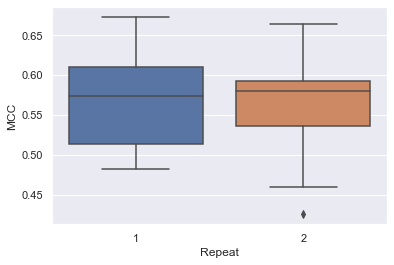

In [10]:
import seaborn as sns

MCC_repeats = {"Repeat1": [], "Repeat2": []}
for i in range(10):
    MCC_repeats["Repeat1"].append(f'split{i}_test_MCC')

for i in range(10,20):
    MCC_repeats["Repeat2"].append(f'split{i}_test_MCC')    

MCC = pd.DataFrame()

MCC_repeats1 = pd.concat([step5.iloc[0:1].T.loc[MCC_repeats["Repeat1"]].reset_index(), 
            pd.Series(np.ones(10).astype("int"))], axis=1, ignore_index=True)

MCC_repeats2 = pd.concat([step5.iloc[0:1].T.loc[MCC_repeats["Repeat2"]].reset_index(), 
            pd.Series(np.ones(10).astype("int"))+1], axis=1, ignore_index=True)            


MCC_repeats = pd.concat([MCC_repeats1, MCC_repeats2], axis=0)
MCC_repeats.columns = ["experiment", "MCC", "Repeat"]

sns.set_theme()
sns.boxplot(data=MCC_repeats, y="MCC", x="Repeat")

<AxesSubplot:xlabel='Repeat', ylabel='NPV'>

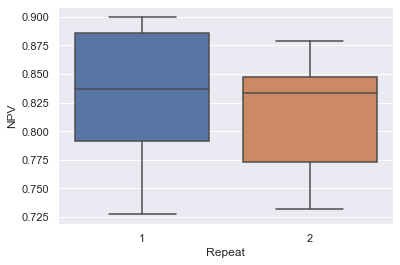

In [11]:
import seaborn as sns

NPV_repeats = {"Repeat1": [], "Repeat2": []}
for i in range(10):
    NPV_repeats["Repeat1"].append(f'split{i}_test_NPV')

for i in range(10,20):
    NPV_repeats["Repeat2"].append(f'split{i}_test_NPV')    

NPV = pd.DataFrame()

NPV_repeats1 = pd.concat([step5.iloc[0:1].T.loc[NPV_repeats["Repeat1"]].reset_index(), 
            pd.Series(np.ones(10).astype("int"))], axis=1, ignore_index=True)

NPV_repeats2 = pd.concat([step5.iloc[0:1].T.loc[NPV_repeats["Repeat2"]].reset_index(), 
            pd.Series(np.ones(10).astype("int"))+1], axis=1, ignore_index=True)            


NPV_repeats = pd.concat([NPV_repeats1, NPV_repeats2], axis=0)
NPV_repeats.columns = ["experiment", "NPV", "Repeat"]

sns.set_theme()
sns.boxplot(data=NPV_repeats, y="NPV", x="Repeat")


High variability among folds is a result of $K=10$ in k-fold cross validation

Run this cell to avoid re-train already trained model

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
results_dataset = pd.read_csv("..\Resultados\RFC\RFC_results.csv")
sns.set_theme()
n_iter = 2000

cutoff = round(n_iter*0.05)
sorted_results = results_dataset.sort_values(by=["rank_test_MCC"])

# Select the 5% best MCC
step4 = sorted_results.iloc[0:cutoff,:]

# Select the best NPV over 5% best MCC
step5 = step4.sort_values(by=["rank_test_NPV"])

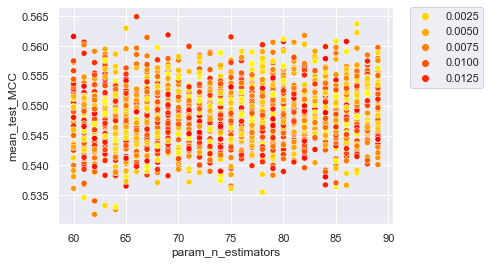

In [5]:
import matplotlib.pyplot as plt
sns.scatterplot(data=results_dataset, x="param_n_estimators", 
              y="mean_test_MCC", hue="param_min_samples_split"
                , palette="autumn_r")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

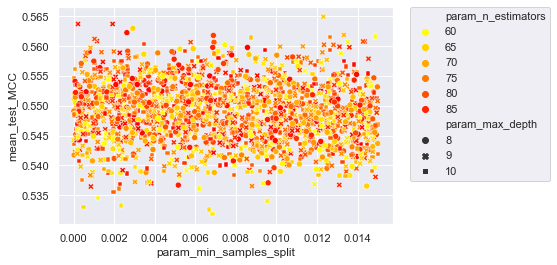

In [6]:
from textwrap import fill
import seaborn as sns
import pandas as pd

color_dict = dict({'sqrt':'red',
                  'log2':'green'})

sns.scatterplot(data=results_dataset, x="param_min_samples_split", 
              y="mean_test_MCC", hue="param_n_estimators", style=results_dataset["param_max_depth"]
                , palette="autumn_r")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#, kind="kde", fill=True                

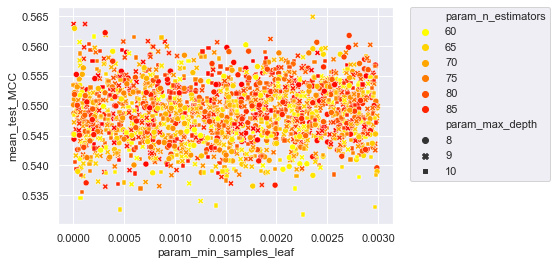

In [7]:
from textwrap import fill
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


results_dataset = pd.read_csv("..\Resultados\RFC\RFC_results.csv")

color_dict = dict({'sqrt':'red',
                  'log2':'green'})

sns.scatterplot(data=results_dataset, x="param_min_samples_leaf", 
              y="mean_test_MCC", hue="param_n_estimators", style=results_dataset["param_max_depth"]
                , palette="autumn_r")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

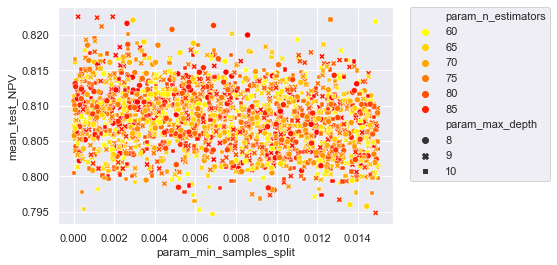

In [8]:
from textwrap import fill
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

results_dataset = pd.read_csv("..\Resultados\RFC\RFC_results.csv")

color_dict = dict({'sqrt':'red',
                  'log2':'green'})

sns.scatterplot(data=results_dataset, x="param_min_samples_split", 
              y="mean_test_NPV", hue="param_n_estimators", style=results_dataset["param_max_depth"]
                , palette="autumn_r")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

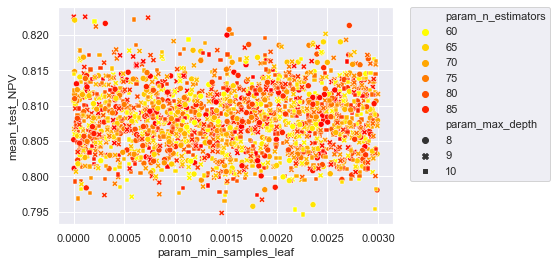

In [9]:
from textwrap import fill
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

results_dataset = pd.read_csv("..\Resultados\RFC\RFC_results.csv")

color_dict = dict({'sqrt':'red',
                  'log2':'green'})

sns.scatterplot(data=results_dataset, x="param_min_samples_leaf", 
              y="mean_test_NPV", hue="param_n_estimators", style=results_dataset["param_max_depth"]
                , palette="autumn_r")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

params = step5["params"].iloc[0]

import ast
params = ast.literal_eval(params)

winner_model = RandomForestClassifier(criterion=params["criterion"], max_depth=params["max_depth"],
                      max_features=params["max_features"], min_samples_leaf=params["min_samples_leaf"],
                      min_samples_split=params["min_samples_split"], n_estimators=params["n_estimators"],
                                     random_state=0)

In [86]:
params

{'criterion': 'entropy',
 'max_depth': 9,
 'max_features': 0.1412288575695536,
 'min_samples_leaf': 0.00011405469762752375,
 'min_samples_split': 0.0019258486522183338,
 'n_estimators': 87}

Negative predictive value:  0.8571428571428571
Mathews Correlation Coefficient:  0.6247213781961704


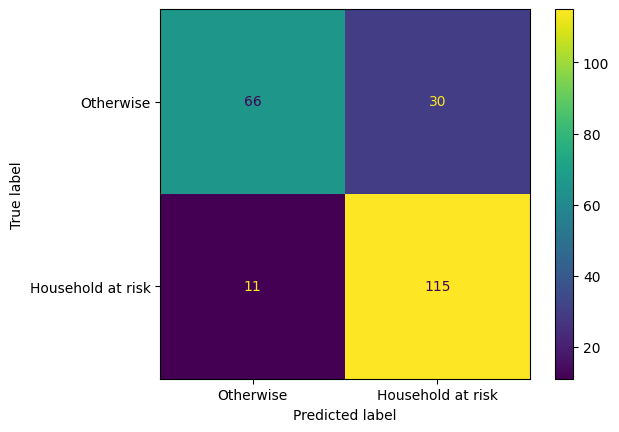

In [71]:
from sklearn.metrics import confusion_matrix

x_train, x_test, y_train, y_test = train_test_split(x, Y, random_state=0, test_size=0.2, stratify=Y)
winner_model.fit(x_train, y_train)
plt.rcParams.update(plt.rcParamsDefault)
predictions = winner_model.predict(x_test)
cm = confusion_matrix(y_test, predictions, labels=winner_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Otherwise", "Household at risk"])
disp.plot()


print('Negative predictive value: ', neg_pred_value(y_test, predictions))
print('Mathews Correlation Coefficient: ', matthews_corrcoef(y_test, predictions))

In [80]:
grid = np.arange(0.1,1,0.01)

res = {"test_size": [], "MCC": [], "NPV": []}

for i in grid:
    x_train, x_test, y_train, y_test = train_test_split(x, Y, random_state=0, test_size=i, stratify=Y)
    winner_model.fit(x_train, y_train)
    predictions = winner_model.predict(x_test)
    res["test_size"].append(i*100)
    res["MCC"].append(matthews_corrcoef(y_test, predictions)*100)
    res["NPV"].append(neg_pred_value(y_test, predictions)*100)
    
results = pd.DataFrame(res)

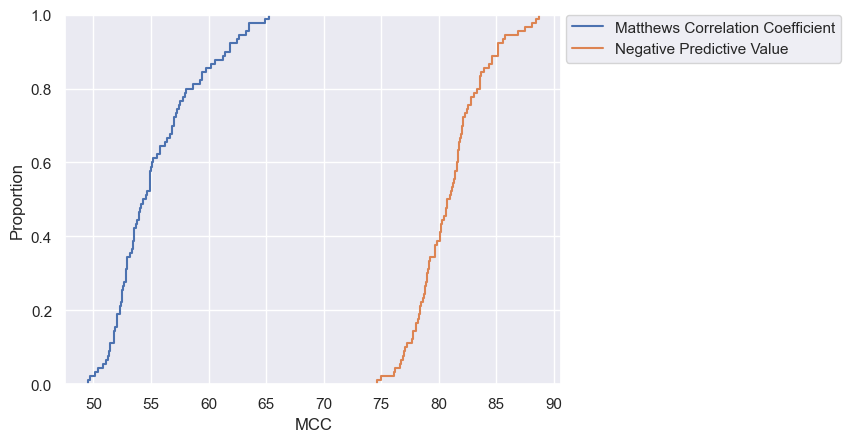

In [88]:
sns.set_theme()
sns.ecdfplot(data=results, x="MCC", label="Matthews Correlation Coefficient")
sns.ecdfplot(data=results, x="NPV", label="Negative Predictive Value")

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

from statsmodels.distributions.empirical_distribution import ECDF

ecdf_MCC = ECDF(results["MCC"])
ecdf_NPV = ECDF(results["NPV"])

In [24]:
a = np.round(results, 4) == 0.7887

results.iloc[a.loc[a["NPV"] == True].index]

,test_size,MCC,NPV
25,35.0,0.545479,0.788732


In [25]:
print("Probability of having MCC higher than 54.55: ", (ecdf_MCC(0.652715)-ecdf_MCC(0.545479))*100)
print("Probability of having NPV higher than 78.87: ", (ecdf_NPV(0.886792)-ecdf_NPV(0.788732))*100)

Probability of having MCC higher than 54.55:  48.88888888888889
Probability of having NPV higher than 78.87:  72.22222222222221


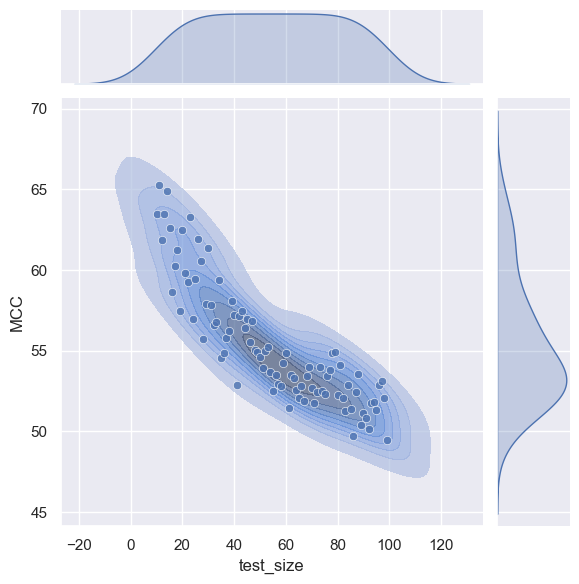

In [89]:
g = sns.jointplot(data=results, x="test_size", y="MCC", kind="kde", fill=True, joint_kws={'alpha': 0.7})
g.plot_joint(sns.scatterplot, alpha=0.8)

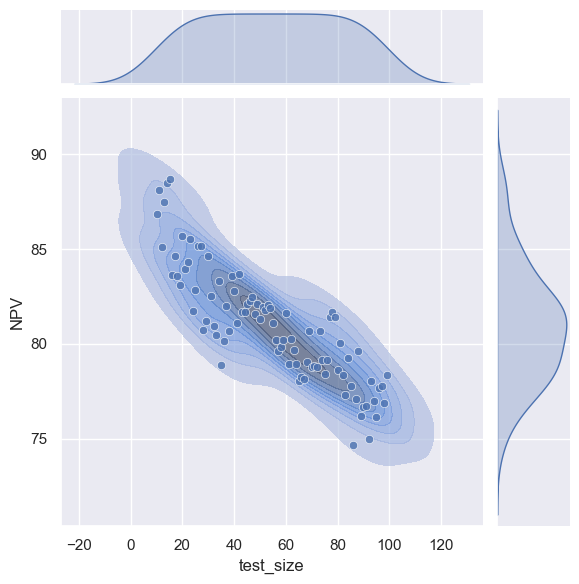

In [90]:
g = sns.jointplot(data=results, x="test_size", y="NPV", kind="kde", fill=True, joint_kws={'alpha': 0.7})
g.plot_joint(sns.scatterplot, alpha=0.8)

In [28]:
import inspect
inspect.signature(sns.jointplot)

<Signature (data=None, *, x=None, y=None, hue=None, kind='scatter', height=6, ratio=5, space=0.2, dropna=False, xlim=None, ylim=None, color=None, palette=None, hue_order=None, hue_norm=None, marginal_ticks=False, joint_kws=None, marginal_kws=None, **kwargs)>

In [29]:
results.to_csv("cross_validation.csv")

# Interpreting the results

<AxesSubplot:xlabel='Importances', ylabel='Features'>

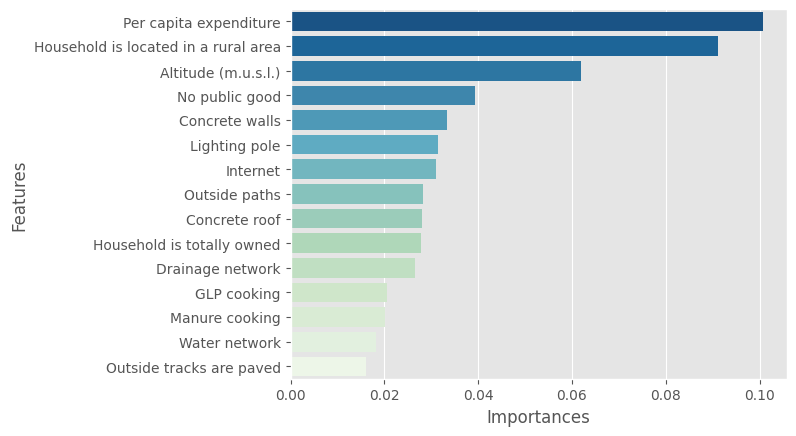

In [84]:
x_train, x_test, y_train, y_test = train_test_split(x, Y, random_state=0, test_size=0.2, stratify=Y)
winner_model.fit(x_train, y_train)
feature_importances = pd.DataFrame({'Features': winner_model.feature_names_in_,
                                    'Importances': winner_model.feature_importances_})

sorted_results = feature_importances.sort_values(by=['Importances'], ascending=False)[0:15]

sorted_results["Features"] = ["Per capita expenditure", "Household is located in a rural area", 
                           "Altitude (m.u.s.l.)", "No public good", "Concrete walls", "Lighting pole",
                           "Internet", "Outside paths", "Concrete roof", "Household is totally owned",
                           "Drainage network", "GLP cooking", "Manure cooking", "Water network",
                           "Outside tracks are paved"]

sns.barplot(data=sorted_results, y='Features', x='Importances', palette='GnBu_r')

Text(0, 0.5, 'Probability of being at risk')

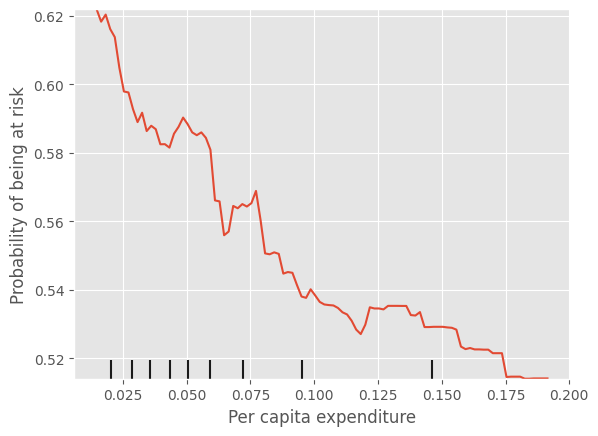

In [79]:
from sklearn.inspection import PartialDependenceDisplay
plt.style.use('ggplot')
partial_dependencies = PartialDependenceDisplay.from_estimator(winner_model, x, features=['gpc']
                                        , response_method='predict_proba', method='brute')
plt.xlabel('Per capita expenditure')
plt.ylabel('Probability of being at risk')

Text(0, 0.5, 'Probability of being at risk')

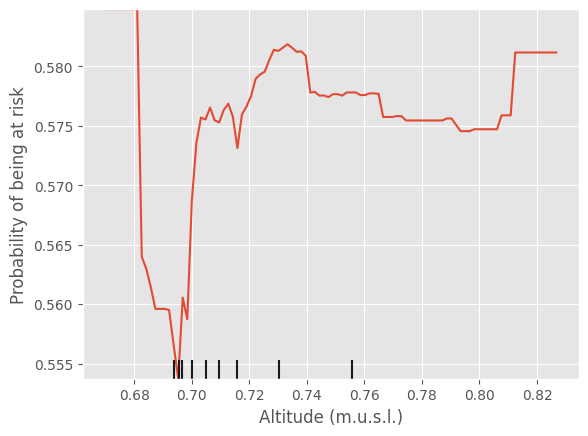

In [78]:
PartialDependenceDisplay.from_estimator(winner_model, x, features=['altura']
                                        , response_method='predict_proba', method='brute')
plt.xlabel('Altitude (m.u.s.l.)')
plt.ylabel('Probability of being at risk')

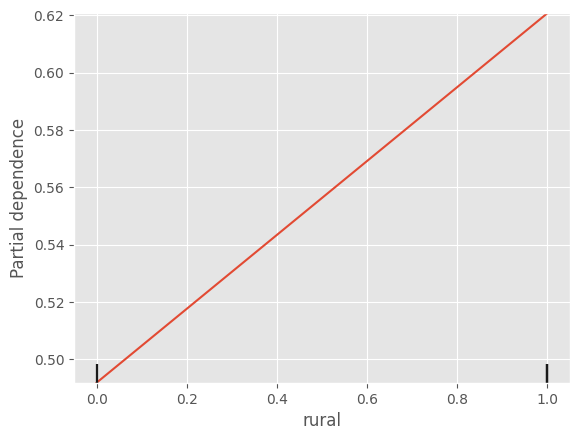

In [49]:
PartialDependenceDisplay.from_estimator(winner_model, X=x, features=['rural']
                                        , response_method='predict_proba', method='brute')

In [54]:
from sklearn.inspection import partial_dependence
resolution = 100

individual_conditional_expectations = (partial_dependence(winner_model, features=['gpc'], X=x, percentiles=(0.05,0.95),
                                grid_resolution=resolution, kind='individual'))

partial_dependencies = pd.DataFrame(individual_conditional_expectations['individual'].reshape(1106,resolution)
            , columns=individual_conditional_expectations['values'])

conditional_expectation = {'mean': [], 'std': []}

for i in np.arange(0,100, 1):
    conditional_expectation['mean'].append(partial_dependencies.iloc[:,i].mean())
    conditional_expectation['std'].append(partial_dependencies.iloc[:,i].std()**2)

conditional_expectation = pd.DataFrame(conditional_expectation)

<AxesSubplot:>

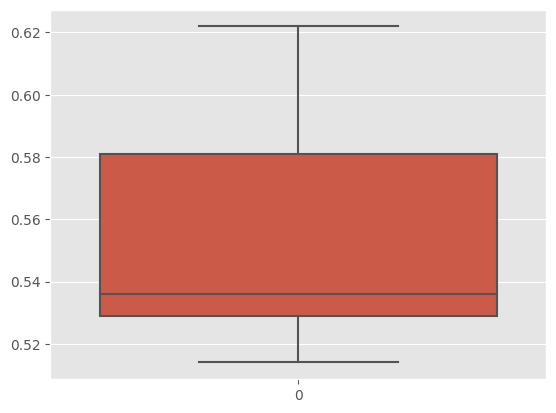

In [58]:
sns.boxplot(conditional_expectation['mean'])

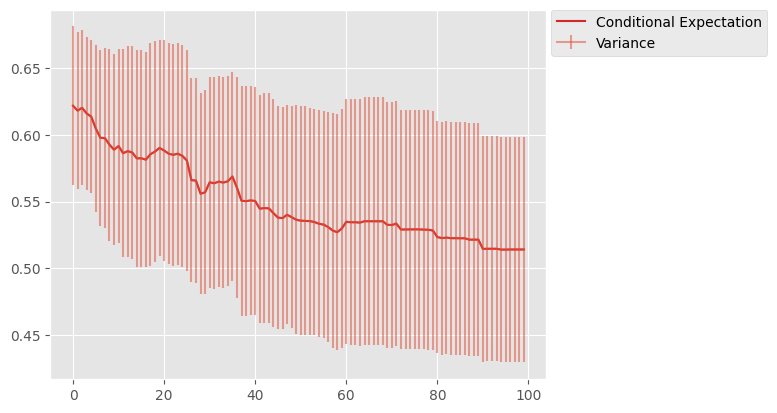

In [61]:
plt.plot(conditional_expectation.index, conditional_expectation['mean'], color='tab:red', label='Conditional Expectation')
plt.errorbar(conditional_expectation.index, conditional_expectation['mean'], yerr=conditional_expectation['std'], alpha=0.5, label='Variance')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

Trade-off between resolution and variance, more resolution implies more variance over each point of the Grid

In [466]:
individual_conditional_expectations['values']

[array([0.01469531, 0.01648074, 0.01826617, 0.0200516 , 0.02183703,
        0.02362245, 0.02540788, 0.02719331, 0.02897874, 0.03076416,
        0.03254959, 0.03433502, 0.03612045, 0.03790587, 0.0396913 ,
        0.04147673, 0.04326216, 0.04504759, 0.04683301, 0.04861844,
        0.05040387, 0.0521893 , 0.05397472, 0.05576015, 0.05754558,
        0.05933101, 0.06111644, 0.06290186, 0.06468729, 0.06647272,
        0.06825815, 0.07004357, 0.071829  , 0.07361443, 0.07539986,
        0.07718529, 0.07897071, 0.08075614, 0.08254157, 0.084327  ,
        0.08611242, 0.08789785, 0.08968328, 0.09146871, 0.09325414,
        0.09503956, 0.09682499, 0.09861042, 0.10039585, 0.10218127,
        0.1039667 , 0.10575213, 0.10753756, 0.10932299, 0.11110841,
        0.11289384, 0.11467927, 0.1164647 , 0.11825012, 0.12003555,
        0.12182098, 0.12360641, 0.12539184, 0.12717726, 0.12896269,
        0.13074812, 0.13253355, 0.13431897, 0.1361044 , 0.13788983,
        0.13967526, 0.14146069, 0.14324611, 0.14

In [64]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaler.fit_transform(data_puno['gpc'].values.reshape(-1, 1))
index = scaler.inverse_transform(pd.DataFrame(individual_conditional_expectations['values'][0], columns=['gpc']))

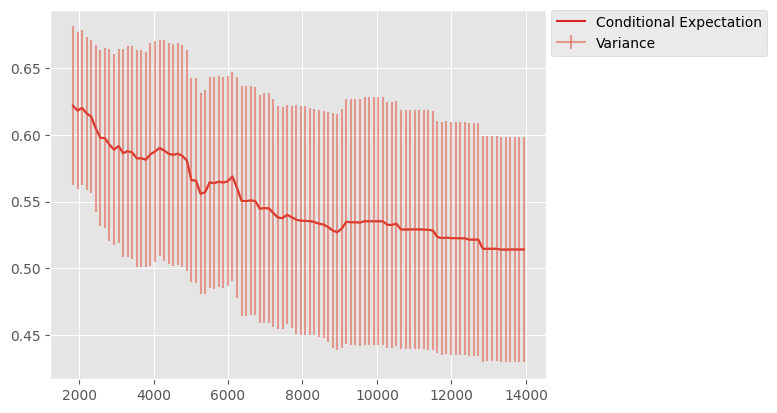

In [65]:
plt.plot(index, conditional_expectation['mean'], color='tab:red', label='Conditional Expectation')
plt.errorbar(index, conditional_expectation['mean'], yerr=conditional_expectation['std'], alpha=0.5, label='Variance')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)